# GO_MWU

started 01/06/2025 - doing this for each of the three pairwise comparisons with HC that resulted in differentially signficiantly methylated genes

following protocol outlined here: [Rank-based Gene Ontology Analysis with Adaptive Clustering (Matz, 2015)](https://github.com/z0on/GO_MWU)

"Basically, the method tests whether the genes belonging to a certain GO category are significantly bunched up near the top or the bottom of the global ranked list of genes, instead of being spread evenly all over it. The test used is called the Mann-Whitney U (MWU) test." [source](https://github.com/z0on/GO_MWU)

**Needed in the same directory:**
- scripts: GO_MWU.R, gomwu_a.pl, gomwu_b.pl, gomwu.functions.R
- GO hierarchy file ([go.obo](http://www.geneontology.org/GO.downloads.ontology.shtml))
- table of GO annotations for your sequences: two-column (gene id - GO terms), tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl to merge them. Do NOT include genes without GO annotations.
- table of measure of interest for your sequences: two columns of comma-separated values: gene id, continuous measure of change such as log(fold-change). To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (1 or 0, i.e., either sgnificant or not). To analyze modules derived from WGCNA, specify 0 for genes not included in the module and the kME value (number between 0 and 1, module membership score) for genes included in the module.

In [2]:
library(tidyverse)
library(ape)

In [3]:
setwd('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu')
getwd()

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu"

## CH vs. HC
control hypoxic vs. hypoxic control (timing of hypoxic stress)

table of measure of interest for sequences: 

In [66]:
allGenes_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CH_vs_HC.csv')

# select only gene id and continuous measure of change (log fold change)
allGenes_CH_lfc <- select(allGenes_CH, X, log2FoldChange)

colnames(allGenes_CH_lfc) <- c('Symbol', 'log2fc')
allGenes_CH_lfc <- allGenes_CH_lfc[!is.na(allGenes_CH_lfc$log2fc),]

head(allGenes_CH_lfc)

# binary measure for significance
allGenes_CH$significant <- ifelse(is.na(allGenes_CH$padj) | allGenes_CH$padj > 0.05, 0, 1)

allGenes_CH_sig <- select(allGenes_CH, X, significant)
colnames(allGenes_CH_sig) <- c('Symbol', 'signif')

head(allGenes_CH_sig)

,Symbol,log2fc
,<chr>,<dbl>
1,LOC111116054,0.000000000
2,LOC111126949,-0.017689935
3,LOC111110729,-0.063561032
4,LOC111112434,0.118262122
5,LOC111120752,0.203890410
7,LOC111128953,-0.002804562


,Symbol,signif
,<chr>,<dbl>
1,LOC111116054,0
2,LOC111126949,0
3,LOC111110729,0
4,LOC111112434,0
5,LOC111120752,0
6,LOC111128944,0


I did both the continuous measure (log2FoldChange) and binary (0 for non-significant, 1 for significant)

In [67]:
write.csv(allGenes_CH_lfc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_CH_lfc.csv', row.names=FALSE, quote = FALSE)

In [68]:
write.csv(allGenes_CH_sig, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_CH_sig.csv', row.names=FALSE, quote=FALSE)

table of GO annotations for your sequences (gene id and GO terms):

In [69]:
# Read the GAF file into R
GOobo <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/Cvirginica_genome/GCF_002022765.2_C_virginica-3.0_gene_ontology.gaf', 
                          sep = "\t", 
                          header = FALSE, 
                          comment.char = "!", 
                          stringsAsFactors = FALSE)

# assign column names
colnames(GOobo) <- c('DB', 'GeneID', 'Symbol', 'Qualifier', 'GO_ID', 'Reference', 'Evidence_Code', 'With,From', 'Aspect', 'Gene_Name', 'Gene_Synonym', 'Type', 'Taxon', 'Date', 'Assigned_By')

# only need gene id and GO terms
gene_GO <- select(GOobo, Symbol, GO_ID)

head(gene_GO)

,Symbol,GO_ID
,<chr>,<chr>
1,LOC111099029,GO:0005261
2,LOC111099029,GO:0098655
3,LOC111099032,GO:0004930
4,LOC111099032,GO:0004930
5,LOC111099032,GO:0005886
6,LOC111099032,GO:0007186


In [70]:
# Aggregate GO IDs for each gene symbol
geneGO <- aggregate(GO_ID ~ Symbol, data = gene_GO, function(x) paste(unique(x), collapse = "; "))

# Print the aggregated data frame
head(geneGO)

,Symbol,GO_ID
,<chr>,<chr>
1,LOC111099029,GO:0005261; GO:0098655
2,LOC111099032,GO:0004930; GO:0005886; GO:0007186
3,LOC111099033,GO:0016020; GO:0022857; GO:0055085
4,LOC111099034,GO:0005515
5,LOC111099036,GO:0008028; GO:0015718; GO:0055085
6,LOC111099039,GO:0004930; GO:0005886; GO:0007189


In [71]:
write.table(geneGO, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes2GO.tab', sep = '\t', row.names = FALSE, quote = FALSE)

#### GO_MWU.R

**molecular function**

continuous measure (log2FoldChange)

In [72]:
# Edit these to match your data file names: 
input="allGenes_CH_lfc.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="MF" # either MF, or BP, or CC
source("gomwu.functions.R")


In [73]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [23]:
mwu_MF_ch <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_MF_allGenes_CH_lfc.csv', sep= ' ')
head(mwu_MF_ch)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,1665,0.09931216,2,5,GO:0000026,"alpha-1,2-mannosyltransferase activity",0.6784797
2,171,0.72876525,5,21,GO:0000030,mannosyltransferase activity,0.9388837
3,773,0.02890507,2,41,GO:0000049,tRNA binding,0.6102001
4,-239,0.76502275,4,8,GO:0000062;GO:0120227;GO:1901567;GO:1901681,acyl-CoA binding,0.9494588
5,667,0.37617952,3,9,GO:0000146,microfilament motor activity,0.7793527
6,-102,0.79309877,3,34,GO:0000149,SNARE binding,0.9555081


In [24]:
filter(mwu_MF_ch, mwu_MF_ch$level == 1)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,0.9974835,1,111,GO:0005198,structural molecule activity,0.9974835
166,0.1818715,1,346,GO:0098772,molecular function regulator,0.7255980
178,0.3064346,1,172,GO:0140110,transcription regulator activity,0.7255980


In [93]:
filter(mwu_MF_ch, mwu_MF_ch$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


no significantly enriched GO terms for molecular function

**biological process**

In [75]:
# Edit these to match your data file names: 
input="allGenes_CH_lfc.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="BP" # either MF, or BP, or CC
source("gomwu.functions.R")


In [76]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [78]:
# Plotting results
results=gomwuPlot(input,goAnnotations,goDivision,
                  absValue=1e-5,  # genes with the measure value exceeding this will be counted as "good genes". This setting is for signed log-pvalues. Specify absValue=0.001 if you are doing Fisher's exact test for standard GO enrichment or analyzing a WGCNA module (all non-zero genes = "good genes").
                  level1=0.05, # FDR threshold for plotting. Specify level1=1 to plot all GO categories containing genes exceeding the absValue.
                  level2=0.05, # FDR cutoff to print in regular (not italic) font.
                  level3=0.01, # FDR cutoff to print in large bold font.
                  txtsize=1.2,    # decrease to fit more on one page, or increase (after rescaling the plot so the tree fits the text) for better "word cloud" effect
                  treeHeight=0.5, # height of the hierarchical clustering tree
                  )

ERROR: Error in `.rowNamesDF<-`(x, value = value): invalid 'row.names' length


In [5]:
mwu_BP_ch <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_BP_allGenes_CH_lfc.csv', sep= ' ')
head(mwu_BP_ch)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,115,0.61561963,2,6,GO:0000012,single strand break repair,0.8846008
2,67,0.61571333,2,18,GO:0000027,ribosomal large subunit assembly,0.8846008
3,-271,0.12691169,4,10,GO:0000028,ribosomal small subunit assembly,0.6039774
4,179,0.04102924,2,42,GO:0000045;GO:0070925;GO:1905037;GO:0007033,organelle assembly,0.4669454
5,-54,0.74003195,7,12,GO:0000054;GO:0033750;GO:0071428;GO:0071426;GO:0006611;GO:0031503,rRNA-containing ribonucleoprotein complex export from nucleus,0.9399743
6,234,0.30712519,3,6,GO:0000055,ribosomal large subunit export from nucleus,0.7996669


looking at the different levels - the levels are the hierarchy of GO terms, 1 being the most general and the higher numbers becoming more specific

In [6]:
filter(mwu_BP_ch, mwu_BP_ch$level == 1)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
-34,0.7471851,1,28,GO:0022414,reproductive process,0.9399743
-8,0.9460357,1,22,GO:0032501,multicellular organismal process,0.9990491
35,0.6640649,1,49,GO:0032502,developmental process,0.9210312


when only looking at the most general GO terms in the hierarchy for CH vs. HC (timing of stress), we see terms for reproductive and developmental process show up, although not significant

In [7]:
mwuBP_ch_level2 <- filter(mwu_BP_ch, mwu_BP_ch$level == 2)

mwuBP_ch_level2 <- head(mwuBP_ch_level2[order(mwuBP_ch_level2$p.adj),], 20)
head(mwuBP_ch_level2)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
98,266,0.003006538,2,40,GO:1903047,mitotic cell cycle process,0.2045305
43,493,0.008459970,2,9,GO:0007154,cell communication,0.2743447
58,177,0.016295537,2,60,GO:0022402,cell cycle process,0.3723792
86,399,0.033202097,2,9,GO:0048856,anatomical structure development,0.4433456
3,179,0.041029237,2,42,GO:0000045;GO:0070925;GO:1905037;GO:0007033,organelle assembly,0.4669454
88,-390,0.049811725,2,8,GO:0051336,regulation of hydrolase activity,0.4846974


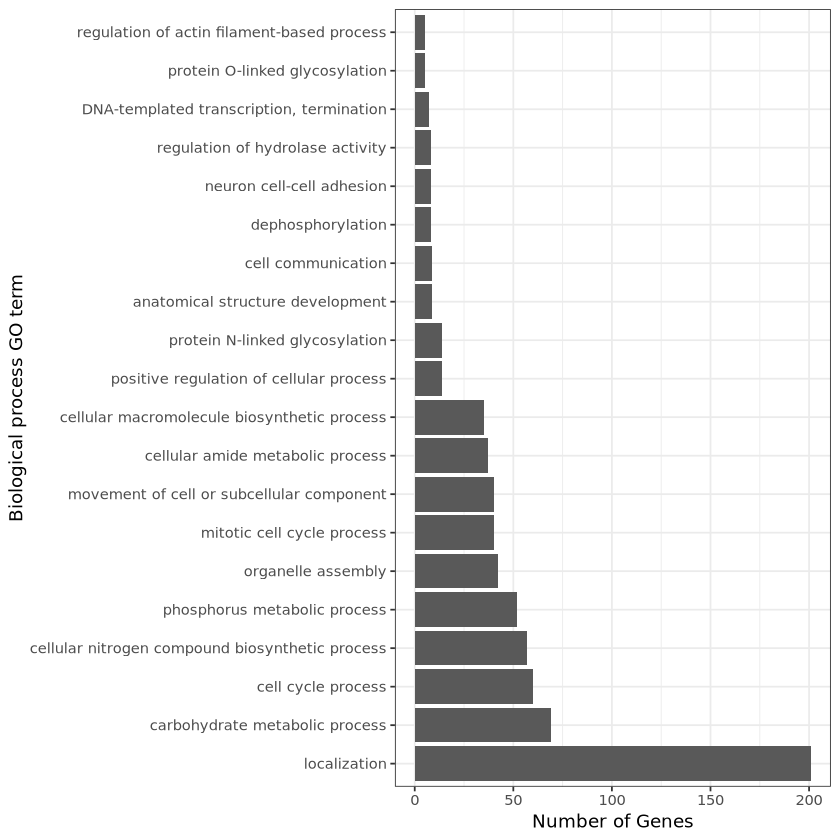

In [56]:
ggplot(mwuBP_ch_level2, aes(x=reorder(name, -nseqs), y=nseqs)) + 
geom_bar(stat = "identity") +
labs(x = 'Biological process GO term', y = 'Number of Genes') +
theme_bw() + 
#theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
coord_flip()

here, I filtered the MWU results for just level 2 terms (so more broader terms in the hierarchy), then pulled out the top 20 terms according to the adjusted p-value and visualized this in a bar plot that is ordered based on the number of genes that are included in the GO term. 

In [94]:
filter(mwu_BP_ch, mwu_BP_ch$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


no significantly enriched GO terms for biological processes

trying again but with **binary measure** (0/1 for non-signif./signif.) to see if that changes anything

this utilizes Fisher's exact test - looking for GO categories that are significantly over-represented among significant genes

In [60]:
# Edit these to match your data file names: 
input="allGenes_CH_sig.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="MF" # either MF, or BP, or CC
source("gomwu.functions.R")

In [61]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Binary classification detected; will perform Fisher's test


1 GO terms at 10% FDR



In [63]:
mwu_MF_ch <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_MF_allGenes_CH_sig.csv', sep= ' ')
head(mwu_MF_ch)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,0,1,5,5,GO:0000026,"alpha-1,2-mannosyltransferase activity",1
2,0,1,4,28,GO:0000030,mannosyltransferase activity,1
3,0,1,4,45,GO:0000049,tRNA binding,1
4,0,1,2,8,GO:0000062;GO:0120227;GO:1901567;GO:1901681,fatty-acyl-CoA binding,1
5,0,1,3,10,GO:0000146,microfilament motor activity,1
6,0,1,2,42,GO:0000149,SNARE binding,1


In [64]:
filter(mwu_MF_ch, mwu_MF_ch$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


In [17]:
# Edit these to match your data file names: 
input="allGenes_CH_sig.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="BP" # either MF, or BP, or CC
source("gomwu.functions.R")

In [18]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Binary classification detected; will perform Fisher's test


0 GO terms at 10% FDR



In [65]:
mwu_BP_ch <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_BP_allGenes_CH_sig.csv', sep= ' ')
head(mwu_BP_ch)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,0,0.03768788,2,7,GO:0000012,single strand break repair,0.8900498
2,0,0.09924269,2,19,GO:0000027,ribosomal large subunit assembly,1.0000000
3,0,0.06379557,2,12,GO:0000028,ribosomal small subunit assembly,1.0000000
4,0,1.00000000,5,47,GO:0000045;GO:0070925;GO:1905037;GO:0007033,organelle assembly,1.0000000
5,0,1.00000000,8,21,GO:0000054;GO:0033750;GO:0071428;GO:0071426;GO:0006405;GO:0006611;GO:0031503;GO:0050658;GO:0051168;GO:0050657;GO:0051236;GO:0006913;GO:0015931;GO:0051169,nucleocytoplasmic transport,1.0000000
6,0,1.00000000,3,9,GO:0000055,ribosomal large subunit export from nucleus,1.0000000


In [66]:
filter(mwu_BP_ch, mwu_BP_ch$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


so doing binary measure does not change the results - in that there are still no significantly enriched GO terms

In [67]:
mwuBP_ch_level2 <- filter(mwu_BP_ch, mwu_BP_ch$level == 2)

mwuBP_ch_level2 <- head(mwuBP_ch_level2[order(mwuBP_ch_level2$p.adj),], 20)

head(mwuBP_ch_level2)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,0,0.03768788,2,7,GO:0000012,single strand break repair,0.8900498
26,0,0.03768788,2,7,GO:0006417;GO:0010608;GO:0034248,regulation of translation,0.8900498
32,0,0.04821103,2,9,GO:0006665;GO:0006643,membrane lipid metabolic process,0.8900498
60,0,0.01253635,2,32,GO:0016192,vesicle-mediated transport,0.8900498
61,0,0.02205345,2,43,GO:0018193,peptidyl-amino acid modification,0.8900498
62,0,0.04296288,2,8,GO:0018205,peptidyl-lysine modification,0.8900498


In [68]:
filter(mwu_BP_ch, mwu_BP_ch$level == 1)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
0,1,1,30,GO:0022414,reproductive process,1
0,1,1,34,GO:0032501,multicellular organismal process,1
0,1,1,57,GO:0032502,developmental process,1


by using binary measure and Fisher's exact test, the level 1 terms remain the same, but the level 2 terms change - still nothing is significantly enriched 

## HH vs. HC
hypoxic hypoxic vs. hypoxic control (continued hypoxic stress vs. removal of hypoxic stress)

table of measure of interest for sequences: 

In [100]:
getwd()

[1] "/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu"

In [69]:
allGenes_HH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/HH_vs_HC.csv')

# select only gene id and continuous measure of change (log fold change)
allGenes_HH_lfc <- select(allGenes_HH, X, log2FoldChange)

colnames(allGenes_HH_lfc) <- c('Symbol', 'log2fc')

head(allGenes_HH_lfc)

# binary measure for significance
allGenes_HH$significant <- ifelse(is.na(allGenes_HH$padj) | allGenes_HH$padj > 0.05, 0, 1)

allGenes_HH_sig <- select(allGenes_HH, X, significant)
colnames(allGenes_HH_sig) <- c('Symbol', 'signif')

head(allGenes_HH_sig)

,Symbol,log2fc
,<chr>,<dbl>
1,LOC111116054,0.023547556
2,LOC111126949,-0.008575931
3,LOC111110729,0.016854142
4,LOC111112434,-0.446553473
5,LOC111120752,-0.332082994
6,LOC111128944,NA


,Symbol,signif
,<chr>,<dbl>
1,LOC111116054,0
2,LOC111126949,0
3,LOC111110729,0
4,LOC111112434,0
5,LOC111120752,0
6,LOC111128944,0


In [102]:
write.csv(allGenes_HH_lfc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_HH_lfc.csv', row.names=FALSE, quote = FALSE)

In [101]:
write.csv(allGenes_HH_sig, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_HH_sig.csv', row.names=FALSE, quote=FALSE)

#### GO_MWU.R

**molecular function**

In [70]:
# Edit these to match your data file names: 
input="allGenes_HH_lfc.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="MF" # either MF, or BP, or CC
source("gomwu.functions.R")


In [104]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [71]:
mwu_MF_hh <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_MF_allGenes_HH_lfc.csv', sep= ' ')
head(mwu_MF_hh)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,-1258,0.21320839,2,5,GO:0000026,"alpha-1,2-mannosyltransferase activity",0.7602279
2,-178,0.71876607,2,21,GO:0000030,mannosyltransferase activity,0.9697456
3,-634,0.07278138,2,41,GO:0000049,tRNA binding,0.5785622
4,628,0.43183942,6,8,GO:0000062;GO:0120227;GO:1901567;GO:1901681,acyl-CoA binding,0.8914580
5,-1446,0.05480457,3,9,GO:0000146,microfilament motor activity,0.5515916
6,-32,0.93406410,2,34,GO:0000149,SNARE binding,0.9801257


In [72]:
filter(mwu_MF_hh, mwu_MF_hh$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


no significantly enriched GO terms for molecular function

In [73]:
filter(mwu_MF_hh, mwu_MF_hh$level == 1)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
60,0.7800027,1,111,GO:0005198,structural molecule activity,0.9697456
-21,0.8638150,1,346,GO:0098772,molecular function regulator,0.9697456
-181,0.2983625,1,172,GO:0140110,transcription regulator activity,0.8324050


**biological process**

In [74]:
# Edit these to match your data file names: 
input="allGenes_HH_lfc.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="BP" # either MF, or BP, or CC
source("gomwu.functions.R")


In [108]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [75]:
mwu_BP_hh <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_BP_allGenes_HH_lfc.csv', sep= ' ')
head(mwu_BP_hh)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,-82,0.72222335,2,6,GO:0000012,single strand break repair,0.9519533
2,-101,0.44475592,7,18,GO:0000027,ribosomal large subunit assembly,0.9512008
3,303,0.08829177,3,10,GO:0000028,ribosomal small subunit assembly,0.5567287
4,-47,0.59043612,2,42,GO:0000045;GO:0070925;GO:1905037;GO:0007033,organelle assembly,0.9512008
5,75,0.64263966,6,12,GO:0000054;GO:0033750;GO:0071428;GO:0071426;GO:0006611;GO:0031503,protein export from nucleus,0.9512008
6,-265,0.24702006,2,6,GO:0000055,ribosomal large subunit export from nucleus,0.8012410


In [110]:
filter(mwu_BP_hh, mwu_BP_hh$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


no significantly enriched GO terms for biological processes

In [81]:
filter(mwu_BP_hh, mwu_BP_hh$level == 1)

l2_BPhh <- filter(mwu_BP_hh, mwu_BP_hh$level == 2)
head(l2_BPhh[order(l2_BPhh$p.adj),], 20)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
-78,0.4661730,1,28,GO:0022414,reproductive process,0.9512008
-59,0.6238311,1,22,GO:0032501,multicellular organismal process,0.9512008
-113,0.1640609,1,49,GO:0032502,developmental process,0.7448365


,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
87,474,0.01146411,2,9,GO:0055082;GO:0048878,chemical homeostasis,0.3664237
7,326,0.02509634,2,15,GO:0000289,nuclear-transcribed mRNA poly(A) tail shortening,0.4240095
79,-434,0.02061801,2,9,GO:0048856,anatomical structure development,0.4240095
88,225,0.02458523,2,32,GO:0065009;GO:0050790,regulation of catalytic activity,0.4240095
13,466,0.06334706,2,5,GO:0000972,transcription-dependent tethering of RNA polymerase II gene DNA at nuclear periphery,0.5135637
39,-384,0.04044699,2,9,GO:0007154,cell communication,0.5135637
83,381,0.05535846,2,8,GO:0051336,regulation of hydrolase activity,0.5135637
89,220,0.04717279,2,26,GO:1901137;GO:1901135,carbohydrate derivative metabolic process,0.5135637
8,-217,0.07099629,2,22,GO:0000387,spliceosomal snRNP assembly,0.5525695


In [90]:
head(mwu_BP_hh[order(mwu_BP_hh$p.adj),], 20)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
35,-526,0.003107508,7,10,GO:0000491,small nucleolar ribonucleoprotein complex assembly,0.3357777
36,-592,0.005287969,8,7,GO:0000492,box C/D snoRNP assembly,0.3357777
51,-578,0.006500247,4,7,GO:0001934;GO:0031401;GO:0042327;GO:0045937;GO:0010562,positive regulation of protein phosphorylation,0.3357777
86,762,0.002407875,4,5,GO:0006664;GO:1903509;GO:0009247;GO:0046467,glycolipid metabolic process,0.3357777
158,-454,0.007395985,5,11,GO:0032270;GO:0031325;GO:0051247;GO:0009893;GO:0010604;GO:0051173,positive regulation of macromolecule metabolic process,0.3357777
196,-389,0.009661005,4,14,GO:0048522;GO:0048518,positive regulation of cellular process,0.3655080
63,522,0.013916724,4,7,GO:0006353,"DNA-templated transcription, termination",0.3664237
97,-560,0.014527814,3,6,GO:0006888,endoplasmic reticulum to Golgi vesicle-mediated transport,0.3664237
209,474,0.011464110,2,9,GO:0055082;GO:0048878,chemical homeostasis,0.3664237


seems like these all have to do with metabolic processes, complex assemblies, activity

## CC vs. HC
control control vs. hypoxic control (initial exposure to hypoxic stress vs. no stress)

table of measure of interest for sequences: 

In [113]:
allGenes_CC <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CC_vs_HC.csv')

# select only gene id and continuous measure of change (log fold change)
allGenes_CC_lfc <- select(allGenes_CC, X, log2FoldChange)

colnames(allGenes_CC_lfc) <- c('Symbol', 'log2fc')

head(allGenes_CC_lfc)

# binary measure for significance
allGenes_CC$significant <- ifelse(is.na(allGenes_CC$padj) | allGenes_CC$padj > 0.05, 0, 1)

allGenes_CC_sig <- select(allGenes_CC, X, significant)
colnames(allGenes_CC_sig) <- c('Symbol', 'signif')

head(allGenes_CC_sig)

,Symbol,log2fc
,<chr>,<dbl>
1,LOC111116054,0.00000000
2,LOC111126949,-0.01938737
3,LOC111110729,-0.06519374
4,LOC111112434,0.07479191
5,LOC111120752,0.01438339
6,LOC111128944,NA


,Symbol,signif
,<chr>,<dbl>
1,LOC111116054,0
2,LOC111126949,0
3,LOC111110729,0
4,LOC111112434,0
5,LOC111120752,0
6,LOC111128944,0


In [124]:
write.csv(allGenes_CC_lfc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_CC_lfc.csv', row.names=FALSE, quote = FALSE)

In [125]:
write.csv(allGenes_CC_sig, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_CC_sig.csv', row.names=FALSE, quote=FALSE)

#### GO_MWU.R

**molecular function**

In [126]:
# Edit these to match your data file names: 
input="allGenes_CC_lfc.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="MF" # either MF, or BP, or CC
source("gomwu.functions.R")

In [127]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [128]:
mwu_MF_cc <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_MF_allGenes_CC_lfc.csv', sep= ' ')
head(mwu_MF_cc)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,916,0.36468387,2,5,GO:0000026,"alpha-1,2-mannosyltransferase activity",0.8429826
2,-102,0.83650913,5,21,GO:0000030,mannosyltransferase activity,0.9956253
3,492,0.16411439,2,41,GO:0000049,tRNA binding,0.6509256
4,372,0.64140733,6,8,GO:0000062;GO:0120227;GO:1901567;GO:1901681,fatty-acyl-CoA binding,0.9535436
5,1359,0.07114113,2,9,GO:0000146,microfilament motor activity,0.5920605
6,-187,0.62934759,3,34,GO:0000149,SNARE binding,0.9535436


In [129]:
filter(mwu_MF_cc, mwu_MF_cc$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


no significantly enriched GO terms for molecular function

**biological process**

In [82]:
# Edit these to match your data file names: 
input="allGenes_CC_lfc.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="BP" # either MF, or BP, or CC
source("gomwu.functions.R")


In [83]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [84]:
mwu_BP_cc <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_BP_allGenes_CC_lfc.csv', sep= ' ')
head(mwu_BP_cc)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,60,0.79489448,6,6,GO:0000012,single strand break repair,0.9547015
2,53,0.68749613,4,18,GO:0000027,ribosomal large subunit assembly,0.9445336
3,-375,0.03477232,4,10,GO:0000028,ribosomal small subunit assembly,0.4239334
4,27,0.75894488,2,42,GO:0000045;GO:0070925;GO:1905037;GO:0007033,organelle assembly,0.9519334
5,5,0.97775236,7,12,GO:0000054;GO:0033750;GO:0071428;GO:0071426;GO:0006611;GO:0031503,ribosomal subunit export from nucleus,0.9903915
6,216,0.34538114,2,6,GO:0000055,ribosomal large subunit export from nucleus,0.7804439


In [133]:
filter(mwu_BP_cc, mwu_BP_cc$p.adj < 0.05)

delta.rank,pval,level,nseqs,term,name,p.adj
<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>


no significantly enriched GO terms for biological processes

In [87]:
l2_BPcc <- filter(mwu_BP_cc, mwu_BP_cc$level == 2)
head(l2_BPcc[order(l2_BPcc$p.adj),], 20)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
96,760,0.002472641,2,5,GO:0061912;GO:0016236,selective autophagy,0.3554175
26,-115,0.012035361,2,164,GO:0006396,RNA processing,0.3648416
64,-466,0.012857855,2,9,GO:0032886,regulation of microtubule-based process,0.3648416
33,178,0.023588750,2,52,GO:0006796;GO:0019637;GO:0006793,phosphorus metabolic process,0.3672817
37,525,0.021933679,2,6,GO:0006888,endoplasmic reticulum to Golgi vesicle-mediated transport,0.3672817
58,176,0.016993592,2,60,GO:0022402,cell cycle process,0.3672817
104,195,0.029203933,2,40,GO:1903047,mitotic cell cycle process,0.3899584
14,437,0.039532420,2,7,GO:0000492,box C/D snoRNP assembly,0.4273266
91,502,0.045621377,2,5,GO:0051049,regulation of transport,0.4707297


In [89]:
# not limiting to just general level
head(mwu_BP_cc[order(mwu_BP_cc$p.adj),], 20)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
51,572,0.007023425,3,7,GO:0001934;GO:0031401;GO:0042327;GO:0045937;GO:0010562,positive regulation of protein phosphorylation,0.3554175
58,-621,0.006771282,4,6,GO:0003352;GO:0060632;GO:0051270,regulation of cellular component movement,0.3554175
106,-646,0.004832417,4,6,GO:0007007;GO:0007006;GO:0061024,membrane organization,0.3554175
212,760,0.002472641,2,5,GO:0061912;GO:0016236,selective autophagy,0.3554175
217,320,0.007828579,3,22,GO:0090407,organophosphate biosynthetic process,0.3554175
66,-115,0.012035361,2,164,GO:0006396,RNA processing,0.3648416
103,-157,0.010509536,3,87,GO:0006974;GO:0033554;GO:0051716;GO:0006281,cellular response to stress,0.3648416
164,-466,0.012857855,2,9,GO:0032886,regulation of microtubule-based process,0.3648416
7,566,0.024269718,5,5,GO:0000070;GO:0000819;GO:0098813,mitotic sister chromatid segregation,0.3672817


seems like these are relating to autophagy, stress response, homeostasis

## overlap of GO-MWU output with og list of significant genes

CH vs. HC biological processes

In [85]:
BP_go <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/BP_allGenes_CH_lfc.csv', sep = '\t')
head(BP_go)
dim(BP_go)

,name,term,lev,seq,value
,<chr>,<chr>,<int>,<chr>,<dbl>
1,supramolecular fiber organization,GO:0007015;GO:0097435,2,LOC111101101,-0.38722520
2,supramolecular fiber organization,GO:0007015;GO:0097435,2,LOC111108074,0.08059783
3,supramolecular fiber organization,GO:0007015;GO:0097435,2,LOC111109780,-1.04879576
4,supramolecular fiber organization,GO:0007015;GO:0097435,2,LOC111113129,-0.33325171
5,supramolecular fiber organization,GO:0007015;GO:0097435,2,LOC111113355,-0.28047982
6,supramolecular fiber organization,GO:0007015;GO:0097435,2,LOC111115662,-0.31195976


[1] 6755    5

In [82]:
sigCH_dmg <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/sig_DMGs/sig_CH_HC_genes.csv')

# remove rowname
sigCH_dmg <- sigCH_dmg[-1]

head(sigCH_dmg)

,symbol,baseMean,log2FC,lfcSE,stat,pvalue,padj,name
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,LOC111099548,42.98619,-1.2672684,0.2026166,-5.020656,5.149523e-07,0.0003099498,kinesin-like protein KIF17
2,LOC111099571,31.11937,-1.4181929,0.2861630,-4.082264,4.459915e-05,0.0069725275,histone RNA hairpin-binding protein-like
3,LOC111099585,36.32548,0.9854391,0.2091056,3.517070,4.363394e-04,0.0332446433,lys-63-specific deubiquitinase BRCC36-like
4,LOC111099930,35.09830,-1.1981548,0.2270953,-4.175140,2.978035e-05,0.0051868387,"uncharacterized LOC111099930, transcript variant X1"
5,LOC111099978,37.23914,1.1530905,0.2612132,3.457293,5.456316e-04,0.0390971051,"oncoprotein-induced transcript 3 protein-like, transcript variant X1"
6,LOC111100608,22.90296,-1.4622657,0.2851646,-4.251109,2.127149e-05,0.0040010349,DDRGK domain-containing protein 1-like


In [86]:
sig_BPgo <- BP_go[sigCH_dmg$symbol %in% BP_go$seq,]
dim(sig_BPgo)
head(sig_BPgo)

[1] 525   5

,name,term,lev,seq,value
,<chr>,<chr>,<int>,<chr>,<dbl>
19,negative regulation of cell cycle,GO:0031570;GO:0000075;GO:0045786,5,LOC111123010,0.63793820
45,chromatin organization,GO:0006325,2,LOC111115365,0.04582489
60,negative regulation of biological process,GO:0048519;GO:0010629;GO:0010605;GO:0009892,3,LOC111101410,-0.41779725
65,negative regulation of biological process,GO:0048519;GO:0010629;GO:0010605;GO:0009892,3,LOC111104183,-0.32647377
70,negative regulation of biological process,GO:0048519;GO:0010629;GO:0010605;GO:0009892,3,LOC111106194,0.00000000
81,negative regulation of biological process,GO:0048519;GO:0010629;GO:0010605;GO:0009892,3,LOC111110780,-0.17750181


In [106]:
write.csv(sig_BPgo, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/go-mwu/sig_BPgo_CHvsHC.csv', row.names = FALSE)

In [104]:
filter(sig_BPgo, sig_BPgo$lev == 1)

name,term,lev,seq,value
<chr>,<chr>,<int>,<chr>,<dbl>
multicellular organismal process,GO:0032501,1,LOC111118186,0.0006947413
multicellular organismal process,GO:0032501,1,LOC111121826,0.0685229190
multicellular organismal process,GO:0032501,1,LOC111129188,0.2317314530
multicellular organismal process,GO:0032501,1,LOC111129615,-0.1613994267
developmental process,GO:0032502,1,LOC111106268,-0.0640153461
developmental process,GO:0032502,1,LOC111126123,-0.1250995576
reproductive process,GO:0022414,1,LOC111119573,-0.3763769259


List of 1
 $ axis.text.x:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : NULL
  ..$ hjust        : num 1
  ..$ vjust        : NULL
  ..$ angle        : num 90
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

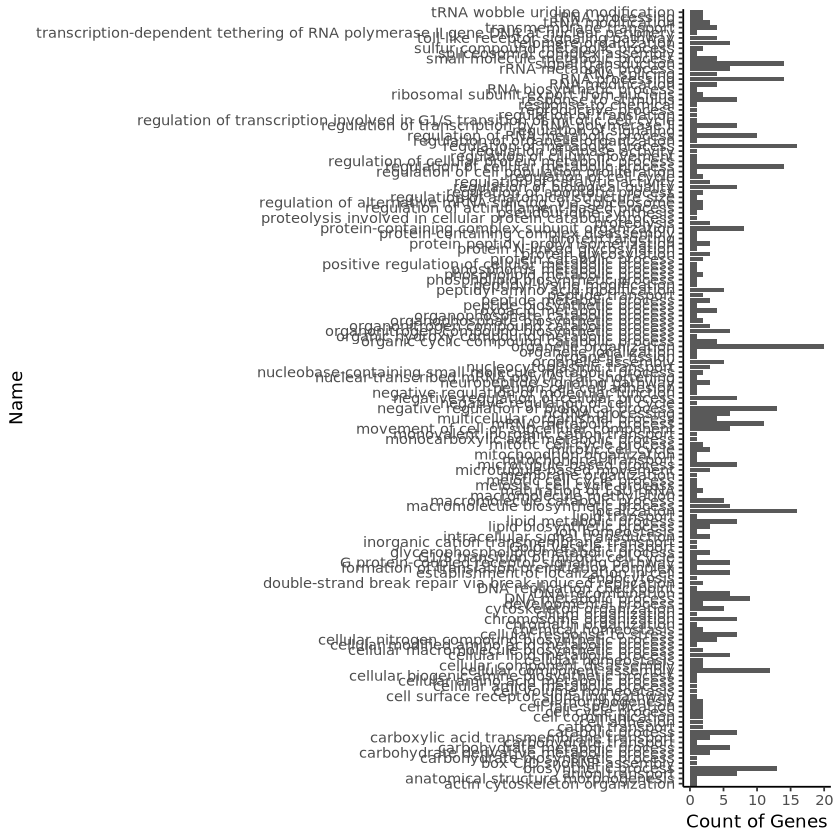

In [89]:
# Load the ggplot2 library
library(ggplot2)
library(dplyr)

# Count the number of genes for each name
name_counts <- sig_BPgo %>%
  group_by(name) %>%
  summarise(count = n())

# Create a bar plot
ggplot(name_counts, aes(x = name, y = count)) +
  geom_bar(stat = "identity") +
  labs(x = "Name", y = "Count of Genes") +
  theme_classic() +
coord_flip()
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

## GO-MWU with log(p-value)

## CH vs. HC
control hypoxic vs. hypoxic control (timing of hypoxic stress)

table of measure of interest for sequences: 

In [11]:
allGenes_CH <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/deseq_res_files/geneFeatures_res/CH_vs_HC.csv')

# take the log of adjusted p-value
allGenes_CH$logP <- log(allGenes_CH$padj)

# only want gene id and log adjusted p-value
logP_CH <- allGenes_CH[,c(1,8)]

# rename gene column
colnames(logP_CH)[1] <- 'gene_id'

head(logP_CH)


,gene_id,logP
,<chr>,<dbl>
1,LOC111116054,NA
2,LOC111126949,NA
3,LOC111110729,NA
4,LOC111112434,NA
5,LOC111120752,NA
6,LOC111128944,NA


I did both the continuous measure (log2FoldChange) and binary (0 for non-significant, 1 for significant)

In [12]:
write.csv(logP_CH, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes_CH_logP.csv', row.names=FALSE, quote = FALSE)

table of GO annotations for your sequences (gene id and GO terms):

In [13]:
# Read the GAF file into R
GOobo <- read.table('/project/pi_sarah_gignouxwolfsohn_uml_edu/Reference_genomes/Cvirginica_genome/GCF_002022765.2_C_virginica-3.0_gene_ontology.gaf', 
                          sep = "\t", 
                          header = FALSE, 
                          comment.char = "!", 
                          stringsAsFactors = FALSE)

# assign column names
colnames(GOobo) <- c('DB', 'GeneID', 'Symbol', 'Qualifier', 'GO_ID', 'Reference', 'Evidence_Code', 'With,From', 'Aspect', 'Gene_Name', 'Gene_Synonym', 'Type', 'Taxon', 'Date', 'Assigned_By')

# only need gene id and GO terms
gene_GO <- select(GOobo, Symbol, GO_ID)

head(gene_GO)

,Symbol,GO_ID
,<chr>,<chr>
1,LOC111099029,GO:0005261
2,LOC111099029,GO:0098655
3,LOC111099032,GO:0004930
4,LOC111099032,GO:0004930
5,LOC111099032,GO:0005886
6,LOC111099032,GO:0007186


In [14]:
# Aggregate GO IDs for each gene symbol
geneGO <- aggregate(GO_ID ~ Symbol, data = gene_GO, function(x) paste(unique(x), collapse = "; "))

# Print the aggregated data frame
head(geneGO)

,Symbol,GO_ID
,<chr>,<chr>
1,LOC111099029,GO:0005261; GO:0098655
2,LOC111099032,GO:0004930; GO:0005886; GO:0007186
3,LOC111099033,GO:0016020; GO:0022857; GO:0055085
4,LOC111099034,GO:0005515
5,LOC111099036,GO:0008028; GO:0015718; GO:0055085
6,LOC111099039,GO:0004930; GO:0005886; GO:0007189


In [71]:
write.table(geneGO, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/allGenes2GO.tab', sep = '\t', row.names = FALSE, quote = FALSE)

#### GO_MWU.R

**biological process**

continuous measure (log adjusted p-value)

In [18]:
# Edit these to match your data file names: 
input="allGenes_CH_logP.csv" # two columns of comma-separated values: gene id, continuous measure of significance. To perform standard GO enrichment analysis based on Fisher's exact test, use binary measure (0 or 1, i.e., either sgnificant or not).
goAnnotations="allGenes2GO.tab" # two-column, tab-delimited, one line per gene, multiple GO terms separated by semicolon. If you have multiple lines per gene, use nrify_GOtable.pl prior to running this script.
goDatabase="go.obo" # download from http://www.geneontology.org/GO.downloads.ontology.shtml
goDivision="BP" # either MF, or BP, or CC
source("gomwu.functions.R")


In [19]:
# Calculating stats. It might take ~3 min for MF and BP. Do not rerun it if you just want to replot the data with different cutoffs, go straight to gomwuPlot. If you change any of the numeric values below, delete the files that were generated in previos runs first.
gomwuStats(input, goDatabase, goAnnotations, goDivision,
           perlPath="perl", # replace with full path to perl executable if it is not in your system's PATH already
           largest=0.1,  # a GO category will not be considered if it contains more than this fraction of the total number of genes
           smallest=5,   # a GO category should contain at least this many genes to be considered
           clusterCutHeight=0.25) # threshold for merging similar (gene-sharing) terms. See README for details.
# There are no GO term at 10% FDR

Continuous measure of interest: will perform MWU test


0 GO terms at 10% FDR



In [20]:
mwu_BP_ch <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_MethylRAD_analysis_2018/analysis/DMGs_analysis/go_mwu/MWU_BP_allGenes_CH_logP.csv', sep= ' ')
head(mwu_BP_ch)

,delta.rank,pval,level,nseqs,term,name,p.adj
,<int>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>
1,-59,0.5232417,5,5,GO:0000012,single strand break repair,0.8969065
2,-9,0.8722809,2,15,GO:0000027,ribosomal large subunit assembly,0.9904127
3,3,0.9695610,2,9,GO:0000028,ribosomal small subunit assembly,0.9904127
4,22,0.6422970,6,20,GO:0000045;GO:1905037;GO:0007033,autophagosome organization,0.9476513
5,79,0.2800125,6,8,GO:0000054;GO:0033750;GO:0071428;GO:0071426;GO:0006611;GO:0031503,protein export from nucleus,0.8440407
6,79,0.3938857,2,5,GO:0000076,DNA replication checkpoint,0.8440407
